In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
import warnings
from sklearn.mixture import GaussianMixture as GMM
import copy
warnings.filterwarnings("ignore")

In [2]:
# Reading the input file
Inputs = pd.read_excel (r'Inputs_ToF - PCA.xlsx')

path_data = (Inputs["Parameters' value"][1])
print("Results path =", path_data)

mass_interval_list_name = str(Inputs["Parameters' value"][2])
print("Mass interval list =", mass_interval_list_name)

# Reading the mass interval list
mass_interval_list = pd.read_csv(mass_interval_list_name, sep="	")

# Define m/z ranges for the analysis
max_value = float(Inputs["Parameters' value"][3])
print("Max m/z for the analysis =", max_value)

min_value = float(Inputs["Parameters' value"][4])
print("Min m/z for the analysis =", min_value)

step = float(Inputs["Parameters' value"][6])
print("m/z step for the analysis =", step)

components_num = float(Inputs["Parameters' value"][6])
if components_num >= 1:
    components_num = int(components_num)
print("PCA components =", components_num)

Results path = D:\Teo\ProGral\Prali\Data\ToF-SIMS\Analyses\Pre_lithiation_project\Pixel_normalization\PCA\Test
Mass interval list = D:\Teo\ProGral\Prali\Data\ToF-SIMS\Analyses\Pre_lithiation_project\Pixel_normalization\PCA\Hans_moisture_mass_interval_list.txt
Max m/z for the analysis = 0.1
Min m/z for the analysis = 149.9
m/z step for the analysis = 4.0
PCA components = 4


In [3]:
# Reading mass interval list and range of peaks 
path = mass_interval_list_name
with open(path, 'r') as f:
    lines = f.readlines()
    f.close()

ranges = {}
for line in lines:
    if line != '\x00':
        if line == lines[0]:
            splitted_line = line.split("	")
            count_col = 0
            for j in splitted_line:
                if j == "Lower Mass (u)":
                    Lower_mass_n = count_col
                if j == "Upper Mass (u)":
                    Upper_mass_n = count_col
                if j == "Assignment":
                    Assignment_n = count_col
                #if j == "Description":
                #    Description_n = count_col
                count_col+=1

        else:
            splitted_line = line.split("	")
            if "total" not in splitted_line:
                Lower_mass = float(splitted_line[Lower_mass_n].replace(",","."))
                Upper_mass = float(splitted_line[Upper_mass_n].replace(",","."))
                Assignment = splitted_line[Assignment_n]
                #Description = splitted_line[Description_n]
                ranges[Assignment] = [Lower_mass, Upper_mass]

peaks_ID = []
for key in ranges:
    peaks_ID.append(key)

In [4]:
# Define range for linear interpolation of data
number_data = int((max_value-min_value)/step)

masses = [min_value]
mass_i = min_value
for i in range(number_data):
    mass_i = mass_i + step
    mass_i = round(mass_i, 4)
    masses.append(mass_i)
    
ranges_int = np.linspace(min_value, max_value, len(masses))

In [5]:
# Initializing dictionaries (first run)
result_dict_name = "PCA_results_mass_list"
folders_not = [result_dict_name, "PCA_results", "loadings"]

Samples_dir = [x[0] for x in os.walk(path_data)]
test_previous = path_data + "\\" + result_dict_name
previous = 0
#if test_previous in Samples_dir:
#    previous = 1

print("previous = ", previous)
    
if previous >= 0: 
    labels = []
    measurements_name = []
    df_all_norm = pd.DataFrame(columns=peaks_ID)
    df_all_cust_norm = pd.DataFrame(columns=peaks_ID) # To use eventually for the custom normalization - not done yet
    for directory in Samples_dir[1:]:
        if "PCA_results" not in directory and "loadings" not in directory and "Box_plot" not in directory:
            sample_name = directory.split("\\")[-1]
            if sample_name not in measurements_name:
                measurements_name.append(sample_name)
            print(sample_name)
            #dict_all[sample_name] = {}
            #normalization_dict[sample_name] = {}
            measurements = os.listdir(directory)
            for i in measurements:
                if ".txt" in i:
                    path = directory + "\\" + str(i)
                    data = pd.read_csv(path, sep="	", header=2)
                    total_count = sum(data["Intensity"])
                    #total_count = 1 # For not normalizing
                    I = data["Intensity"].tolist()
                    m_z = data["m/z"].tolist()
                    I_norm = [i/total_count for i in I]
                    labels.append(sample_name)
                    meas_Is = {}
                    Areas = []
                    for key in peaks_ID:
                        count_In = 0
                        #area_i = 0
                        meas_Is[key] = {}
                        meas_Is[key]["m/z"] = []
                        meas_Is[key]["In"] = []
                        low_l = ranges[key][0]
                        up_l = ranges[key][1]
                        for m in range(len(m_z)):
                            mz_i = m_z[m]
                            In_i = I_norm[m]
                            if mz_i > low_l and mz_i < up_l:
                                meas_Is[key]["m/z"].append(mz_i)
                                meas_Is[key]["In"].append(In_i)
                                count_In = count_In + In_i
                            if mz_i > up_l:
                                area_i = np.trapz(meas_Is[key]["In"], x=meas_Is[key]["m/z"])
                                Areas.append(area_i)
                                break
                    df_all_norm.loc[str(i)] = Areas       
                    
    df_all_norm["label"] = labels

previous =  0
5min_air
C1_20_1h
Ref_pre_lithiated_30


In [6]:
# Local scaling peak by peak
for i in df_all_norm:
    if i != "label":
        df_all_norm[i] = df_all_norm[i] / float(max(df_all_norm[i]))

In [7]:
# Perform PCA
PCA_model = PCA(n_components=components_num)
X = df_all_norm.drop('label', axis=1)
PCA_res = PCA_model.fit_transform(X)
#print(PCA_res)

# Make list of PCs identified
count_p = 1
PCA_names = []
for p in range(PCA_res.shape[1]):
    name = "PC" + str(count_p)
    PCA_names.append(name)
    count_p+=1
    
# Make a dataframe with PCA results and associated label
PCA_res_df = pd.DataFrame(PCA_res, columns=PCA_names)
PCA_res_df["label"] = labels

In [8]:
# Results folder
directory_res = path_data + "\\" + str(result_dict_name)
directory_load = directory_res + "\\loadings"
try: 
    os.makedirs(directory_res)
except:
    pass
try: 
    os.makedirs(directory_load)
except:
    pass

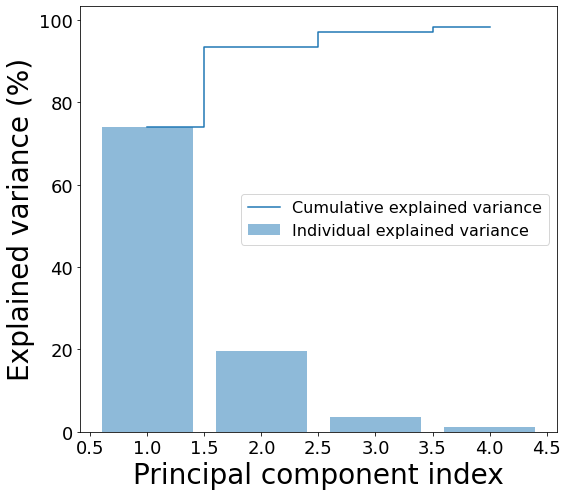

In [9]:
# Checking how much variability is explained by each PC

exp_var_pca = PCA_model.explained_variance_ratio_
fig = plt.figure(figsize=(8, 7))
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca*100, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues*100, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance (%)', fontsize=28)
plt.xlabel('Principal component index', fontsize=28)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='best', fontsize=16)
plt.tight_layout()
plt.show()
path_save = directory_res + "\\Explained_variance.png"
fig.savefig(path_save)

In [10]:
# Getting sorted the loading for each PC and transform back the index n m/z

PC_list = []
for i in range(len(exp_var_pca)):
    PC_i = "PC" + str(i+1)
    PC_list.append(PC_i)
#print(PC_list)
    
loadings = pd.DataFrame(PCA_model.components_.T, columns=PC_list) 
loadings["peaks"] = peaks_ID
#print(loadings) # Check if the sum of the square of the coefficient for each PC gives 1 or not 

def rec_mz(PCname):
    PC_r = loadings.sort_values(PCname, ascending=False)
    PC = pd.DataFrame()
    PC[PCname] = PC_r[PCname]
    PC["peaks"] = PC_r["peaks"]
    csv_save = directory_load + "\\" + str(PCname) + ".csv"
    PC.to_csv(csv_save, index=False)
    return PC

#PC1 = rec_mz("PC1")
#if len(exp_var_pca) > 1:
#    PC2 = rec_mz("PC2")
#if len(exp_var_pca) > 2:
#    PC3 = rec_mz("PC3")
#if len(exp_var_pca) > 3:
#    PC4 = rec_mz("PC4")

PC1 = rec_mz("PC1")
for i in range(1, 100):
    name_PC = "PC" + str(i+1)
    if len(exp_var_pca) > i:
        PCi = rec_mz(name_PC)

In [11]:
# Recovery of the loadings
loadings = pd.DataFrame(PCA_model.components_.T, columns=PC_list)
loadings["peaks"] = peaks_ID

In [12]:
# Row renaming for later plottings
PCA_res_df_ren = pd.DataFrame()
PCA_res_df_ren["PC1"] = PCA_res_df["PC1"]
PCA_res_df_ren["PC2"] = PCA_res_df["PC2"]
PCA_res_df_ren.rename(index = PCA_res_df["label"], inplace=True)
                               
loadings_ren = pd.DataFrame()
loadings_ren["PC1"] = loadings["PC1"]
loadings_ren["PC2"] = loadings["PC2"]
loadings_ren["PC3"] = loadings["PC3"]
loadings_ren["PC4"] = loadings["PC4"]
loadings_ren.rename(index=loadings["peaks"], inplace=True)

In [13]:
# Absolute values and row renaming for later plottings
PCA_res_df_re_abs = pd.DataFrame()
PCA_res_df_re_abs["PC1"] = abs(PCA_res_df["PC1"])
PCA_res_df_re_abs["PC2"] = abs(PCA_res_df["PC2"])
PCA_res_df_re_abs.rename(index = PCA_res_df["label"], inplace=True)
                               
loadings_re_abs = pd.DataFrame()
loadings_re_abs["PC1"] = abs(loadings["PC1"])
loadings_re_abs["PC2"] = abs(loadings["PC2"])
loadings_re_abs.rename(index=loadings["peaks"], inplace=True)

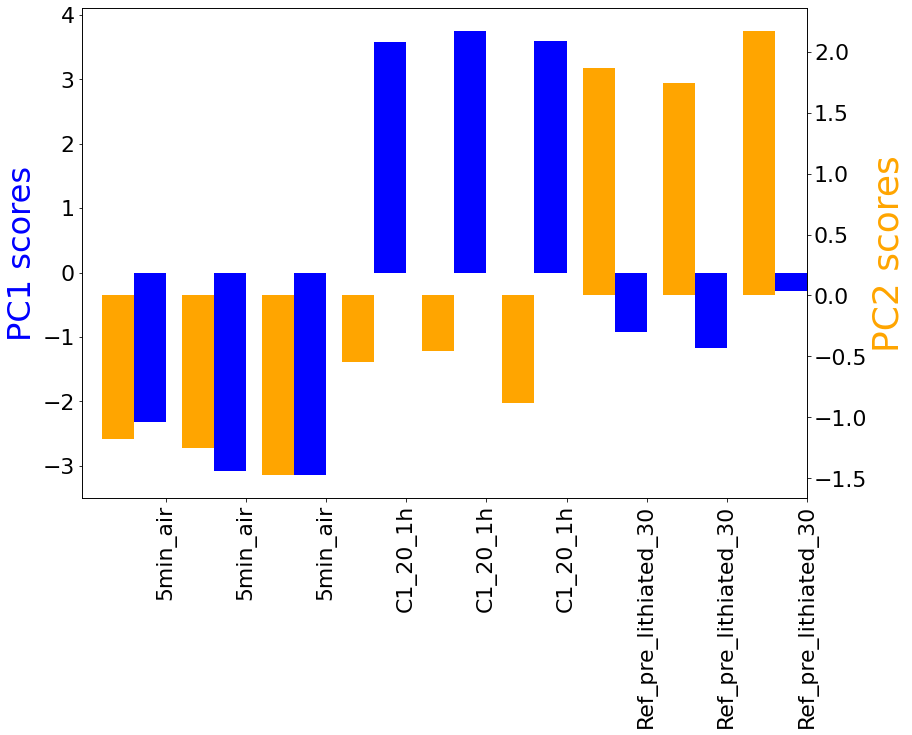

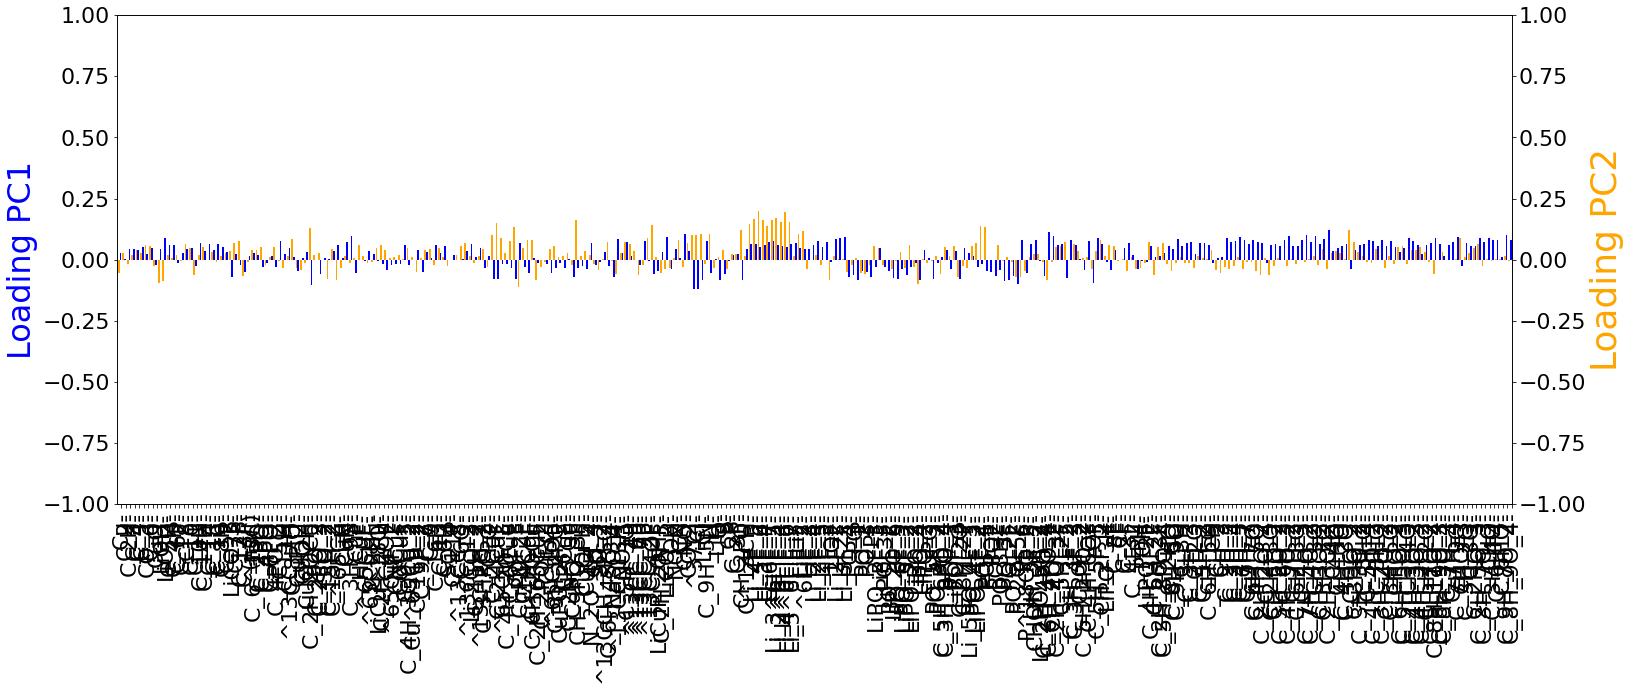

In [14]:
# Plotting PCs values for the different samples - no absolute value
fig = plt.figure(figsize=(13, 9))

ax1 = fig.add_subplot(1,1,1)

width = 0.4
PCA_res_df_ren.PC1.plot(kind="bar", color="blue", width=width, position=1)
plt.ylabel('PC1 scores', color="Blue", fontsize=32)
plt.yticks(fontsize=22)
#plt.xlabel('Plasma time', fontsize=32)
plt.xticks(fontsize=22, rotation=90)
#ax1.set_ylim([-7e-8, 9e-8])
#ax1.set_ylim([-1.2, 3.2])

ax2 = ax1.twinx()
PCA_res_df_ren.PC2.plot(kind="bar", color="orange", ax=ax2, width=width, position=2)
ax2.set_ylabel('PC2 scores', color="orange", fontsize=36)
plt.yticks(fontsize=22)
#ax2.set_ylim([-7e-8, 9e-8])
#ax2.set_ylim([-1.2, 3.2])
plt.show()
path_save = directory_res + "\\PC_values_per_sample.png" # Black plot, I do not get why
fig.savefig(path_save)

# Plotting loading of each PC with respect to the peaks in the mass interval list
fig = plt.figure(figsize=(25, 9))

ax1 = fig.add_subplot(1,1,1)

width = 0.4
loadings_ren.PC1.plot(kind="bar", color="blue", width=width, position=1)
plt.ylabel('Loading PC1', color="Blue", fontsize=32)
plt.yticks(fontsize=22)
ax1.set_ylim([-1, 1])
plt.xticks(fontsize=22, rotation=90)

ax2 = ax1.twinx()
loadings_ren.PC2.plot(kind="bar", color="orange", ax=ax2, width=width, position=2)
ax2.set_ylabel('Loading PC2', color="orange", fontsize=36)
plt.yticks(fontsize=22)
ax2.set_ylim([-1, 1])
plt.show()
path_save = directory_res + "\\loading_per_PC_and_peaks.png" # Black plot, I do not get why
fig.savefig(path_save)

In [15]:
#Identify important peaks for PC1 and PC2
loadings_ren_high_PC1 = loadings_ren[abs(loadings_ren["PC1"])>0.05]
loadings_ren_high_PC1_list = loadings_ren_high_PC1.index.tolist()
loadings_ren_high_PC2 = loadings_ren[abs(loadings_ren["PC2"])>0.05]
loadings_ren_high_PC2_list = loadings_ren_high_PC2.index.tolist()
print("Most important one for PC1 - not ordered")
print(loadings_ren_high_PC1)
print("")
print("Most important one for PC2 - not ordered")
print(loadings_ren_high_PC2)
print("")

#Identify important peaks for PC3 and PC4
loadings_ren_high_PC3 = loadings_ren[abs(loadings_ren["PC3"])>0.05]
loadings_ren_high_PC3_list = loadings_ren_high_PC3.index.tolist()
loadings_ren_high_PC4 = loadings_ren[abs(loadings_ren["PC4"])>0.05]
loadings_ren_high_PC4_list = loadings_ren_high_PC4.index.tolist()
print("Most important one for PC3 - not ordered")
print(loadings_ren_high_PC3)
print("")
print("Most important one for PC4 - not ordered")
print(loadings_ren_high_PC4)

Most important one for PC1 - not ordered
                 PC1       PC2       PC3       PC4
C_5-        0.051721  0.025395  0.007066 -0.003264
LiO_2-      0.087830 -0.085494 -0.014344 -0.011719
C_5H-       0.059160  0.020630  0.032939 -0.015501
C_4H-       0.061308  0.007432  0.022207 -0.024900
C_10H-      0.068663  0.019961 -0.002147 -0.023910
...              ...       ...       ...       ...
CHO-        0.090393  0.002397  0.003982  0.035950
C_3H_4O-    0.081022 -0.006279  0.022915  0.027343
C_6H_4-     0.081905  0.003577  0.016490 -0.019255
C_9H_7O_2-  0.099547  0.015657 -0.029130 -0.028007
C_8H_9O_4-  0.080502 -0.003687  0.016723  0.020194

[158 rows x 4 columns]

Most important one for PC2 - not ordered
                  PC1       PC2       PC3       PC4
Cu-          0.028188 -0.054917  0.034318 -0.069868
CO_3-        0.022048  0.060330 -0.005181 -0.045482
C_6-         0.046312  0.055155 -0.011186 -0.027467
LiOH-        0.042690 -0.093759  0.060994  0.067145
LiO_2-       0.087830

In [16]:
# Saving important peaks info for printing
#PC1 and PC2
imp_loadings_ren_1_2 = copy.copy(loadings_ren)
idexes = []

imp_loadings_ren_1_2 = imp_loadings_ren_1_2.drop(columns=["PC3", "PC4"])

for i in range(len(imp_loadings_ren_1_2)):
    index_i = imp_loadings_ren_1_2.index[i]
    idexes.append(index_i)
    
for index_i in idexes:
    if index_i in loadings_ren_high_PC1_list or index_i in loadings_ren_high_PC2_list:
        continue
    else:
        imp_loadings_ren_1_2 = imp_loadings_ren_1_2.drop(index_i)

#PC3 and PC4
imp_loadings_ren_3_4 = copy.copy(loadings_ren)
idexes = []

imp_loadings_ren_3_4 = imp_loadings_ren_3_4.drop(columns=["PC1", "PC2"])

for i in range(len(imp_loadings_ren_3_4)):
    index_i = imp_loadings_ren_3_4.index[i]
    idexes.append(index_i)
    
for index_i in idexes:
    if index_i in loadings_ren_high_PC3_list or index_i in loadings_ren_high_PC4_list:
        continue
    else:
        imp_loadings_ren_3_4 = imp_loadings_ren_3_4.drop(index_i)

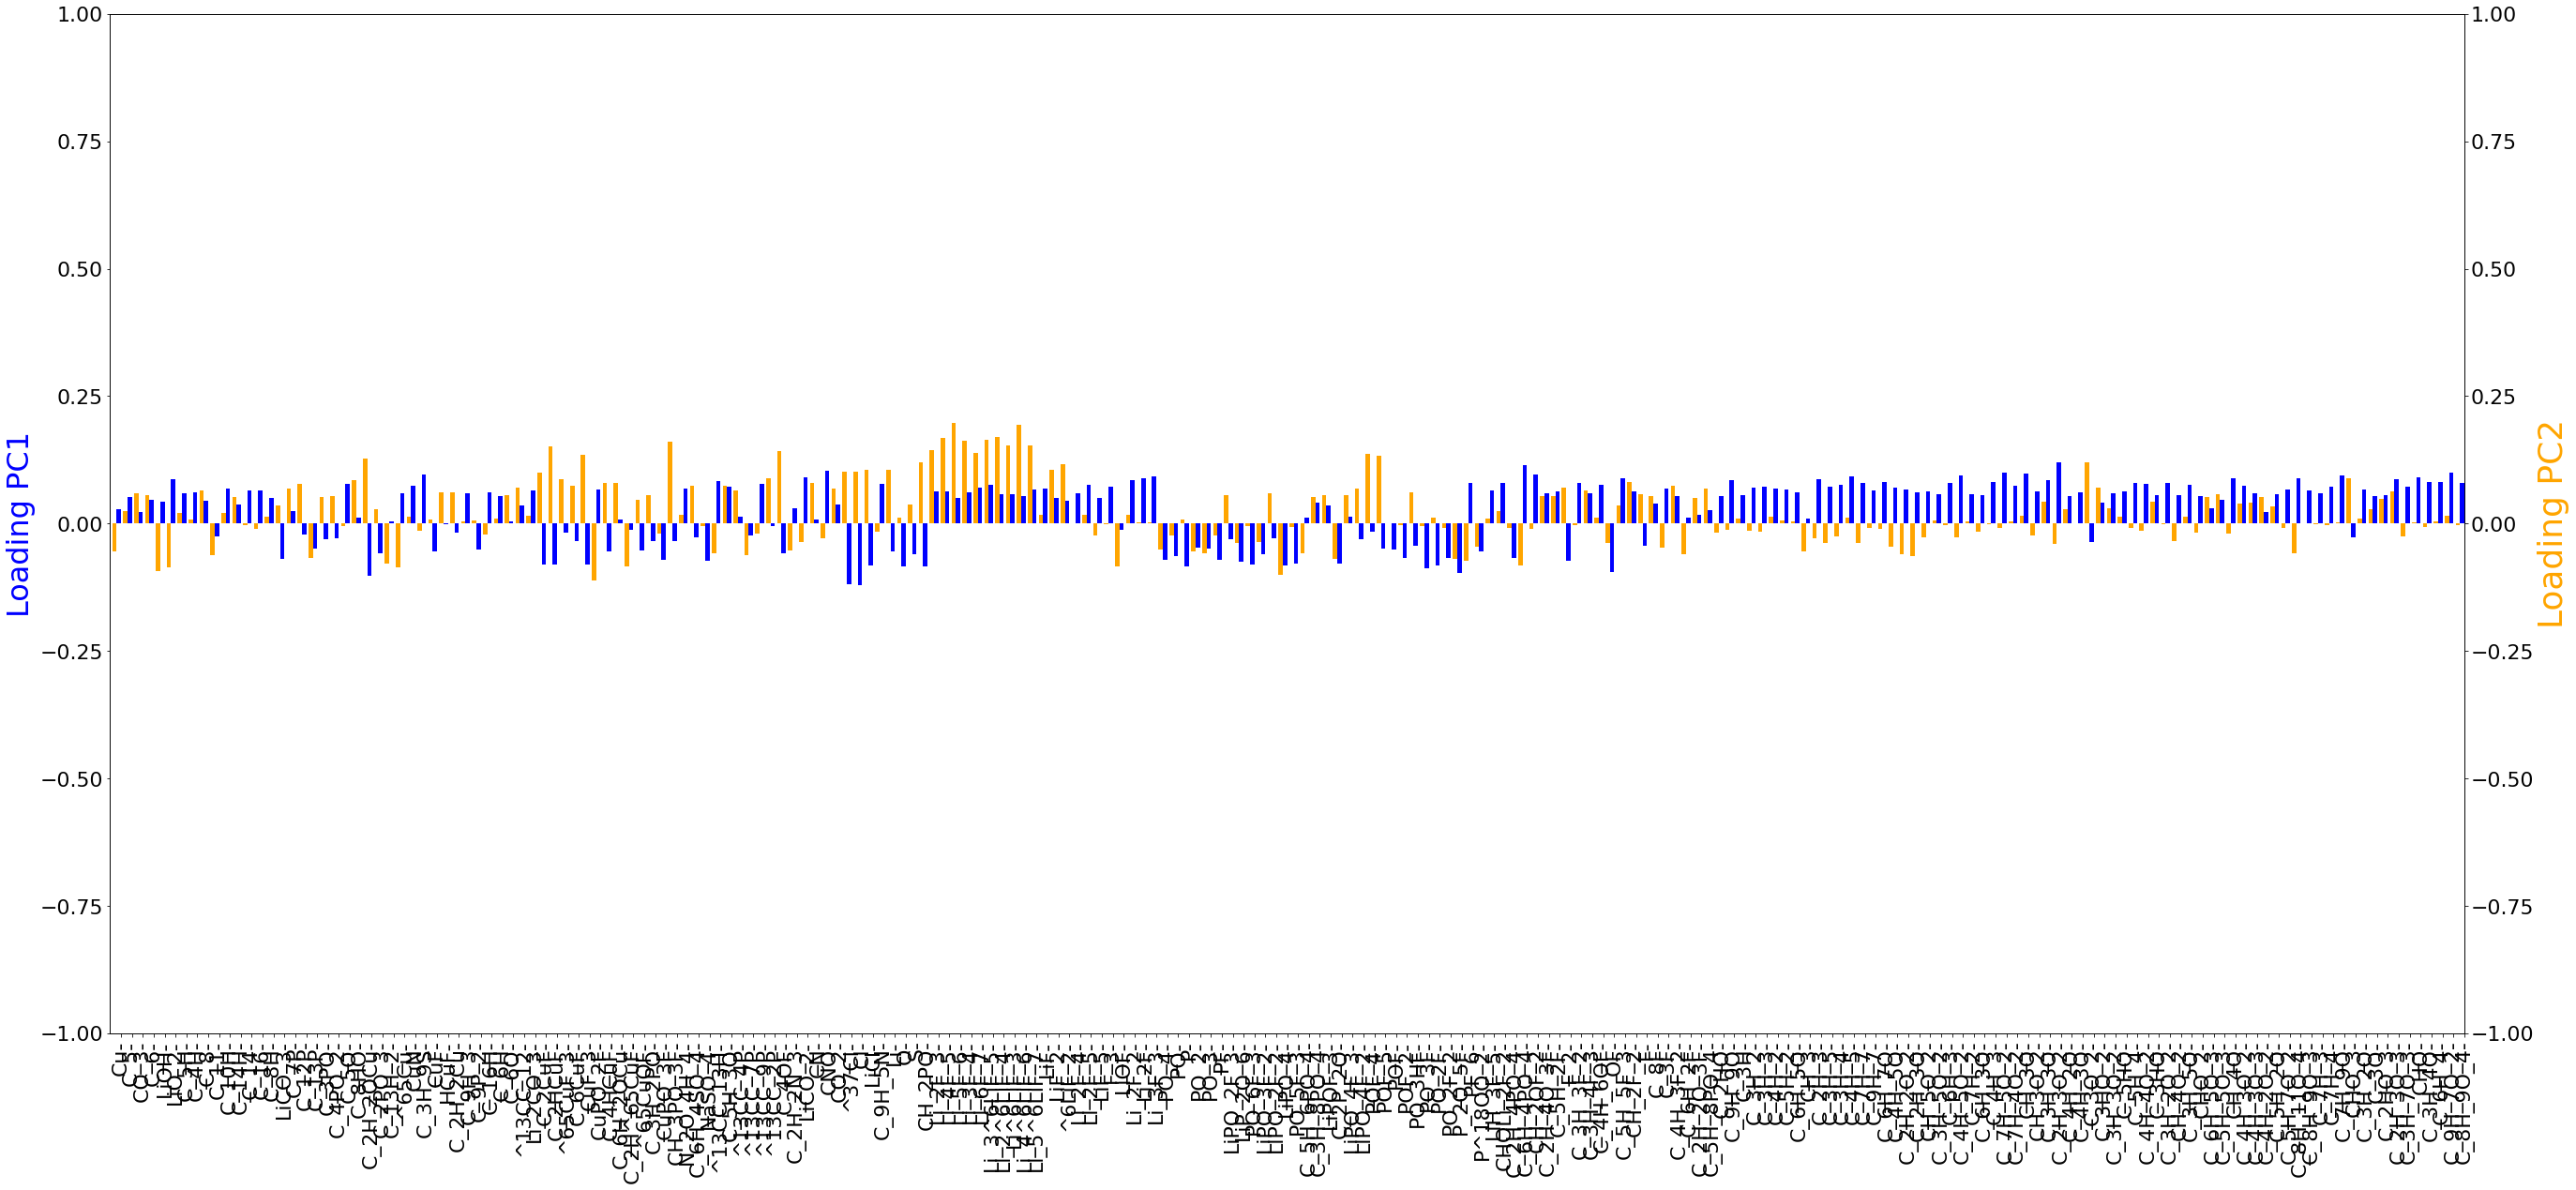

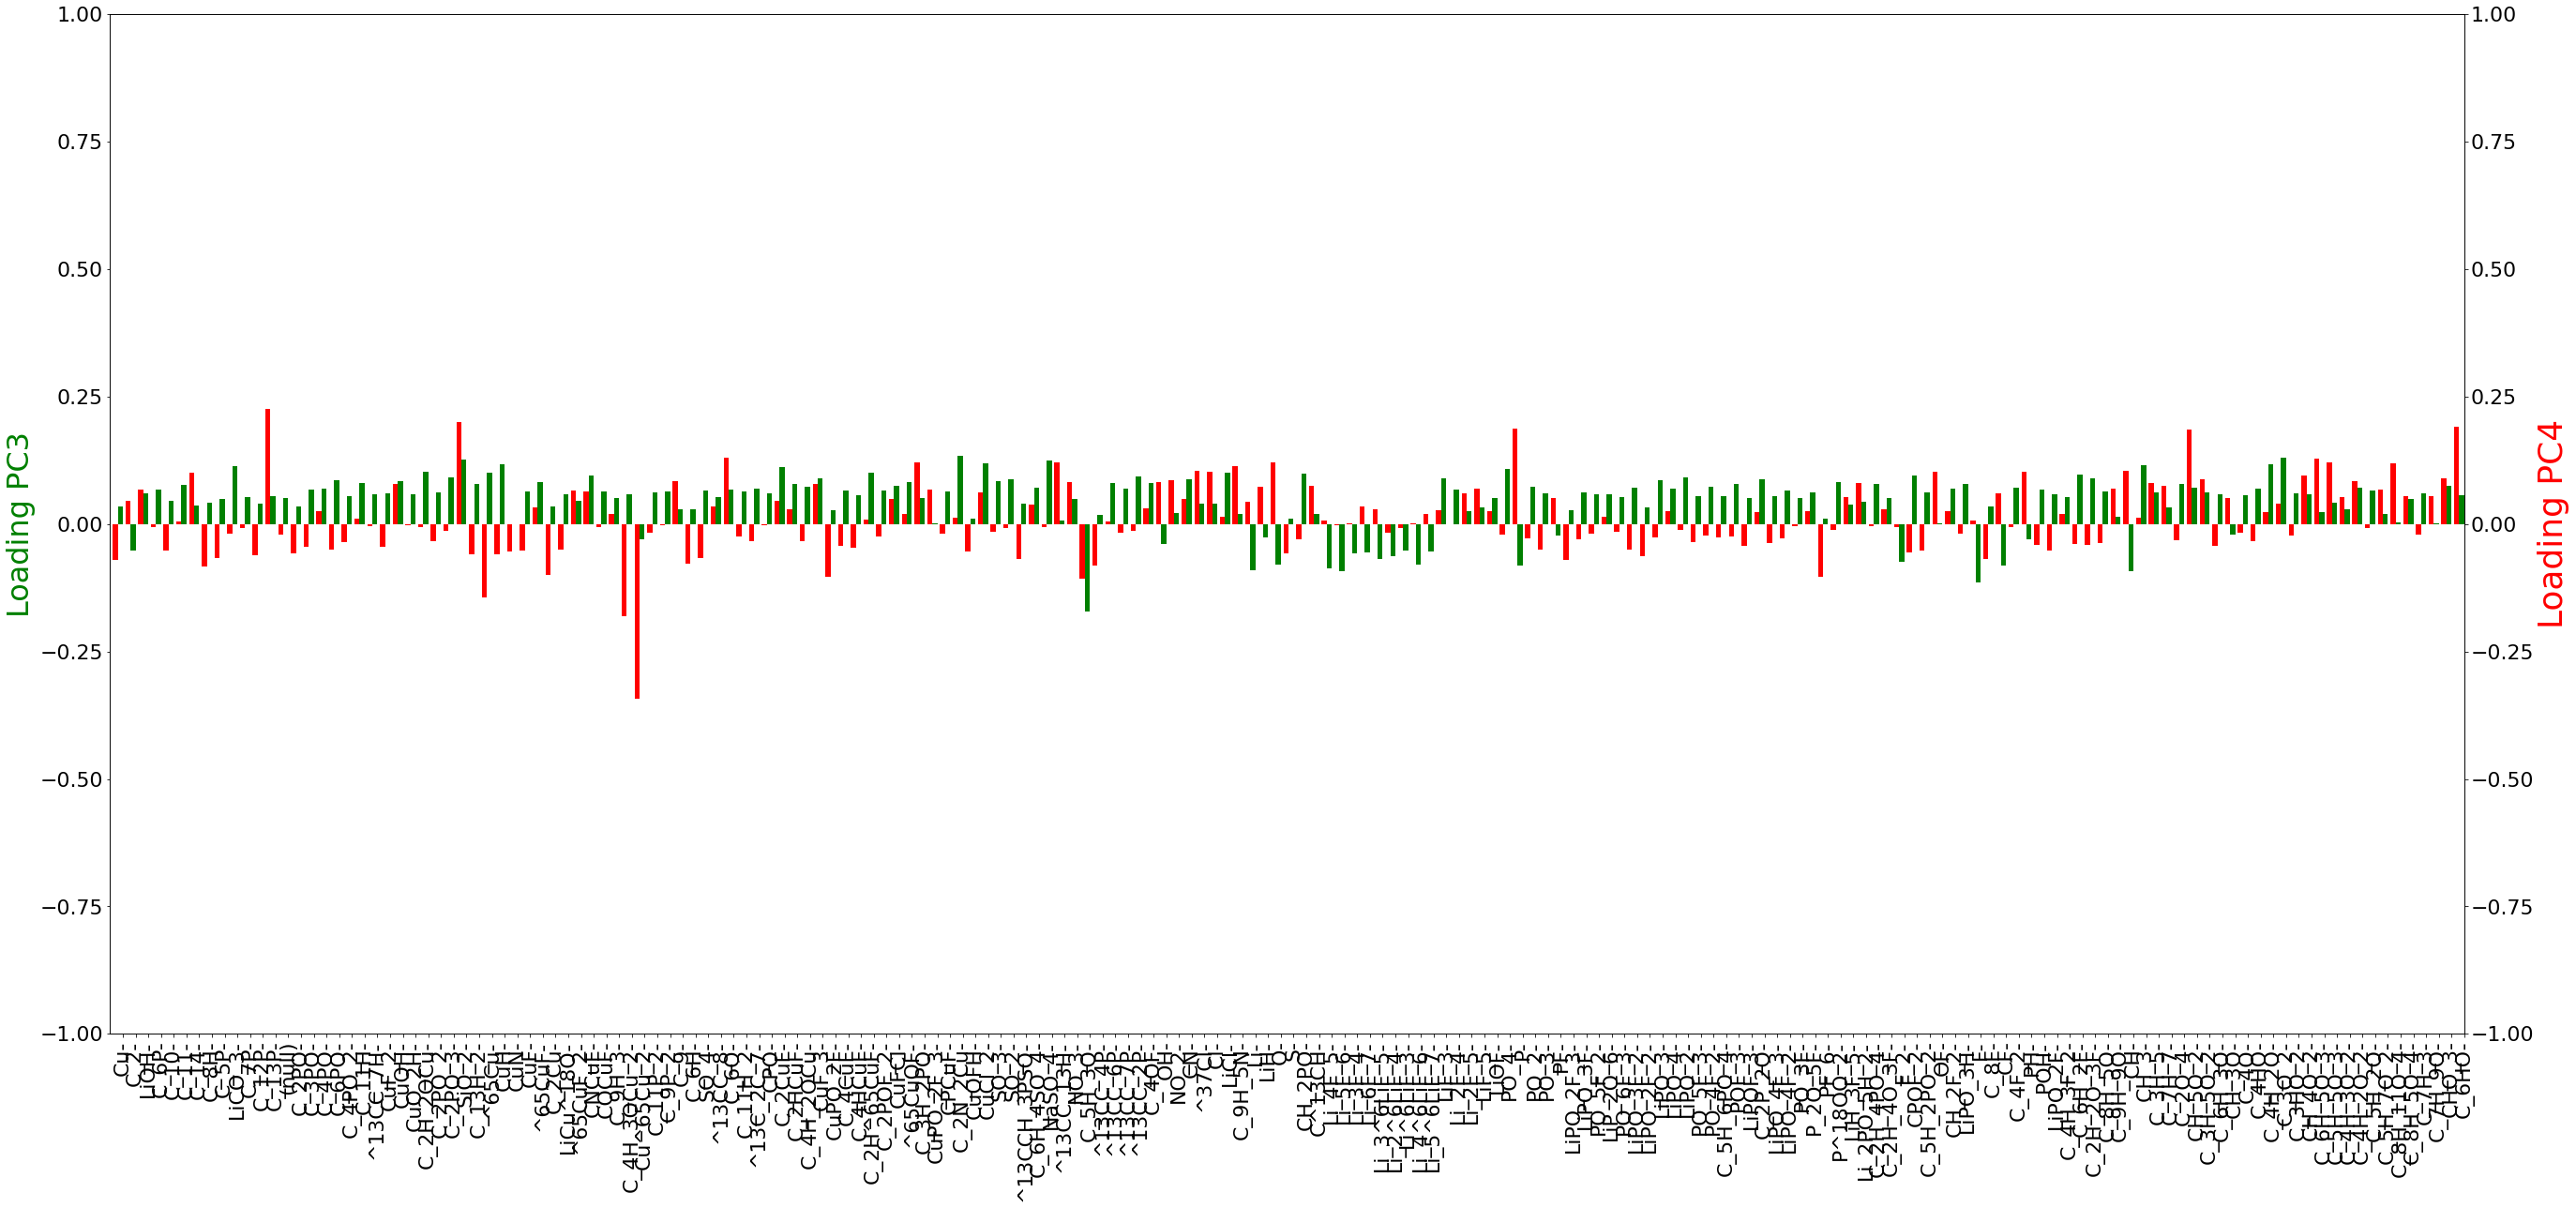

In [17]:
# Plotting loading for important peaks
# PC1 and PC2
fig = plt.figure(figsize=(45, 20))

ax1 = fig.add_subplot(1,1,1)

width = 0.4
imp_loadings_ren_1_2.PC1.plot(kind="bar", color="blue", width=width, position=1)
plt.ylabel('Loading PC1', color="Blue", fontsize=32)
plt.yticks(fontsize=22)
ax1.set_ylim([-1, 1])
plt.xticks(fontsize=22, rotation=90)

ax2 = ax1.twinx()
imp_loadings_ren_1_2.PC2.plot(kind="bar", color="orange", ax=ax2, width=width, position=2)
ax2.set_ylabel('Loading PC2', color="orange", fontsize=36)
plt.yticks(fontsize=22)
ax2.set_ylim([-1, 1])
plt.show()
path_save = directory_res + "\\loading_for_important_peaks_PC1_PC2.png"
fig.savefig(path_save)

# PC3 and PC4
fig = plt.figure(figsize=(45, 20))

ax1 = fig.add_subplot(1,1,1)

width = 0.4
imp_loadings_ren_3_4.PC3.plot(kind="bar", color="green", width=width, position=1)
plt.ylabel('Loading PC3', color="green", fontsize=32)
plt.yticks(fontsize=22)
ax1.set_ylim([-1, 1])
plt.xticks(fontsize=22, rotation=90)

ax2 = ax1.twinx()
imp_loadings_ren_3_4.PC4.plot(kind="bar", color="red", ax=ax2, width=width, position=2)
ax2.set_ylabel('Loading PC4', color="red", fontsize=36)
plt.yticks(fontsize=22)
ax2.set_ylim([-1, 1])
plt.show()
path_save = directory_res + "\\loading_for_important_peaks_PC3_PC4.png"
fig.savefig(path_save)

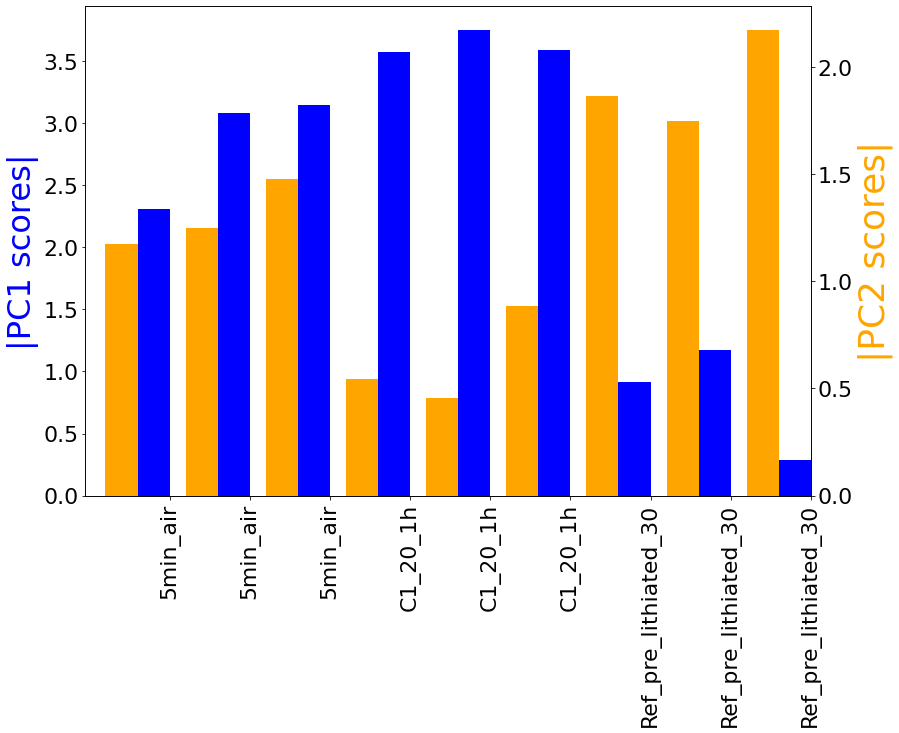

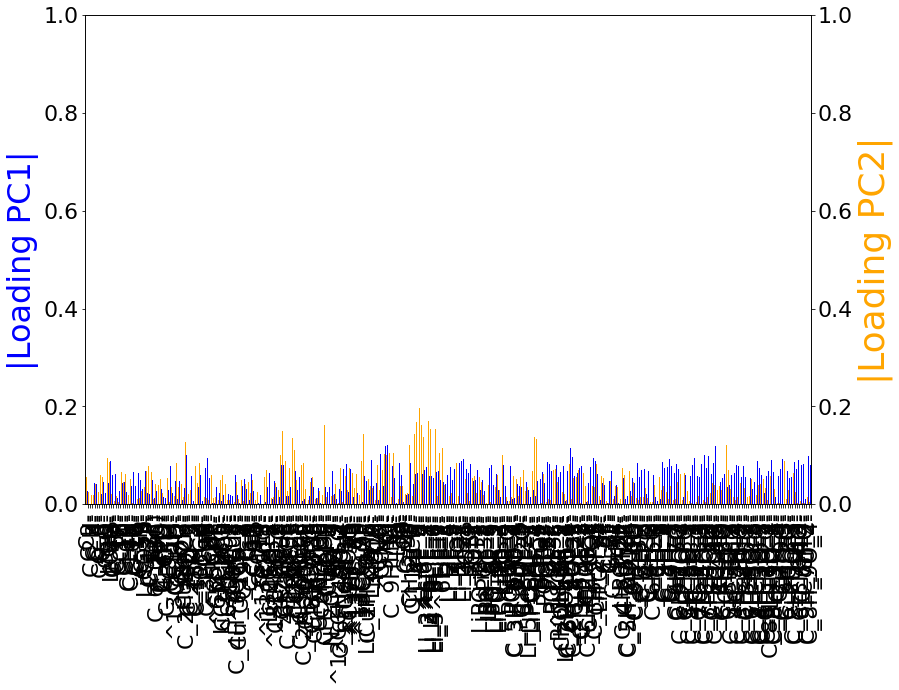

In [18]:
# Plotting PCs values for the different samples - absolute value
fig = plt.figure(figsize=(13, 9))

ax1 = fig.add_subplot(1,1,1)

width = 0.4
PCA_res_df_re_abs.PC1.plot(kind="bar", color="blue", width=width, position=1)
plt.ylabel('|PC1 scores|', color="Blue", fontsize=32)
plt.yticks(fontsize=22)
#plt.xlabel('Plasma time', fontsize=32)
plt.xticks(fontsize=22, rotation=90)
#ax1.set_ylim([0, 9e-8])

ax2 = ax1.twinx()
PCA_res_df_re_abs.PC2.plot(kind="bar", color="orange", ax=ax2, width=width, position=2)
ax2.set_ylabel('|PC2 scores|', color="orange", fontsize=36)
plt.yticks(fontsize=22)
#ax2.set_ylim([0, 9e-8])
plt.show()
path_save = directory_res + "\\PC_values_per_sample_abs.png" # Black plot, I do not get why
fig.savefig(path_save)

# Plotting loading of each PC with respect to the peaks in the mass interval list - absolute value
fig = plt.figure(figsize=(13, 9))

ax1 = fig.add_subplot(1,1,1)

width = 0.4
loadings_re_abs.PC1.plot(kind="bar", color="blue", width=width, position=1)
plt.ylabel('|Loading PC1|', color="Blue", fontsize=32)
plt.yticks(fontsize=22)
ax1.set_ylim([-0, 1])
plt.xticks(fontsize=22, rotation=90)

ax2 = ax1.twinx()
loadings_re_abs.PC2.plot(kind="bar", color="orange", ax=ax2, width=width, position=2)
ax2.set_ylabel('|Loading PC2|', color="orange", fontsize=36)
plt.yticks(fontsize=22)
ax2.set_ylim([-0, 1])
plt.show()
path_save = directory_res + "\\loading_per_PC_and_peaks_abs.png" # Black plot, I do not get why
fig.savefig(path_save)

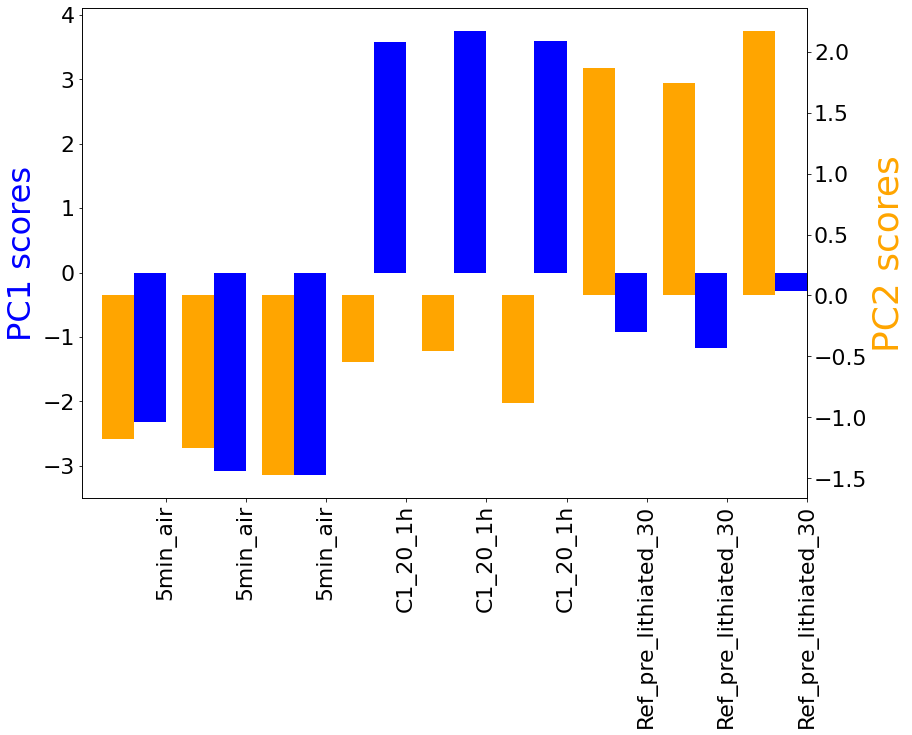

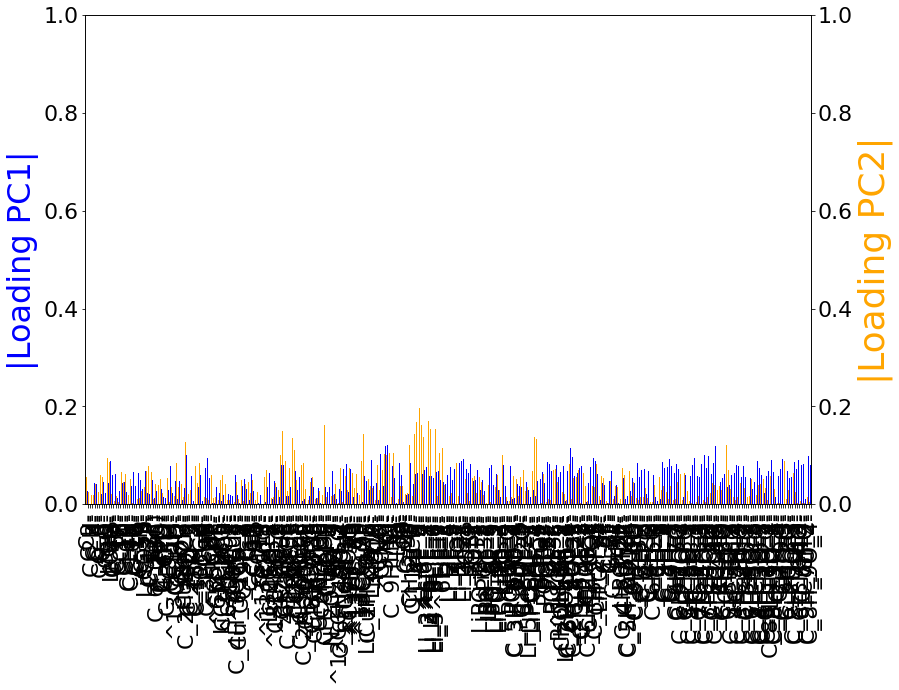

In [19]:
# Plotting PCs values for the different samples - mixed
fig = plt.figure(figsize=(13, 9))

ax1 = fig.add_subplot(1,1,1)

width = 0.4
PCA_res_df_ren.PC1.plot(kind="bar", color="blue", width=width, position=1)
plt.ylabel('PC1 scores', color="Blue", fontsize=32)
plt.yticks(fontsize=22)
#plt.xlabel('Plasma time', fontsize=32)
plt.xticks(fontsize=22, rotation=90)
#ax1.set_ylim([-7e-8, 9e-8])

ax2 = ax1.twinx()
PCA_res_df_ren.PC2.plot(kind="bar", color="orange", ax=ax2, width=width, position=2)
ax2.set_ylabel('PC2 scores', color="orange", fontsize=36)
plt.yticks(fontsize=22)
#ax2.set_ylim([-7e-8, 9e-8])
plt.show()

# Plotting loading of each PC with respect to the peaks in the mass interval list - absolute value
fig = plt.figure(figsize=(13, 9))

ax1 = fig.add_subplot(1,1,1)

width = 0.4
loadings_re_abs.PC1.plot(kind="bar", color="blue", width=width, position=1)
plt.ylabel('|Loading PC1|', color="Blue", fontsize=32)
plt.yticks(fontsize=22)
ax1.set_ylim([-0, 1])
plt.xticks(fontsize=22, rotation=90)

ax2 = ax1.twinx()
loadings_re_abs.PC2.plot(kind="bar", color="orange", ax=ax2, width=width, position=2)
ax2.set_ylabel('|Loading PC2|', color="orange", fontsize=36)
plt.yticks(fontsize=22)
ax2.set_ylim([-0, 1])
plt.show()

In [ ]:
# Saving PC values
csv_save = directory_res + "\\" + "PCs values.csv"
PCA_res_df.to_csv(csv_save, index=False)

In [20]:
# Define minimal and maximal value for PC1 and PC2
min1 = min(PCA_res_df["PC1"])
max1 = max(PCA_res_df["PC1"])
min2 = min(PCA_res_df["PC2"])
max2 = max(PCA_res_df["PC2"])

if min1 > 0:
    min1 = min(PCA_res_df["PC1"])-0.05*min(PCA_res_df["PC1"])
else:
    min1 = min(PCA_res_df["PC1"])+0.05*min(PCA_res_df["PC1"])
    
if max1 > 0:   
    max1 = max(PCA_res_df["PC1"])+0.05*max(PCA_res_df["PC1"])
else:
    max1 = max(PCA_res_df["PC1"])-0.05*max(PCA_res_df["PC1"])

if min2 >  0:
    min2 = min(PCA_res_df["PC2"])-0.05*min(PCA_res_df["PC2"])
else:
    min2 = min(PCA_res_df["PC2"])+0.05*min(PCA_res_df["PC2"])

if max2 > 0:
    max2 = max(PCA_res_df["PC2"])+0.05*max(PCA_res_df["PC2"])
else:
    max2 = max(PCA_res_df["PC2"])-0.05*max(PCA_res_df["PC2"])

number_points = 10

step1 = (max1-min1)/number_points
step2 = (max2-min2)/number_points

PC1_list = [min1]
PC2_list = [min2]
value1 = min1
value2 = min2
for n in range(number_points-1):
    value1 = value1 + step1
    PC1_list.append(value1)
    value2 = value2 + step2
    PC2_list.append(value2)
    
x_coverage = []
y_coverage = []
for i2 in PC2_list:
    for i1 in PC1_list:
        x_coverage.append(i1)
        y_coverage.append(i2)

In [21]:
# Define minimal and maximal value for PC3 and PC4
if len(exp_var_pca) > 3:
    min1 = min(PCA_res_df["PC3"])
    max1 = max(PCA_res_df["PC3"])
    min2 = min(PCA_res_df["PC4"])
    max2 = max(PCA_res_df["PC4"])

    if min1 > 0:
        min1 = min(PCA_res_df["PC3"])-0.05*min(PCA_res_df["PC3"])
    else:
        min1 = min(PCA_res_df["PC3"])+0.05*min(PCA_res_df["PC3"])

    if max1 > 0:   
        max1 = max(PCA_res_df["PC3"])+0.05*max(PCA_res_df["PC3"])
    else:
        max1 = max(PCA_res_df["PC3"])-0.05*max(PCA_res_df["PC3"])

    if min2 >  0:
        min2 = min(PCA_res_df["PC4"])-0.05*min(PCA_res_df["PC4"])
    else:
        min2 = min(PCA_res_df["PC4"])+0.05*min(PCA_res_df["PC4"])

    if max2 > 0:
        max2 = max(PCA_res_df["PC4"])+0.05*max(PCA_res_df["PC4"])
    else:
        max2 = max(PCA_res_df["PC4"])-0.05*max(PCA_res_df["PC4"])

    #number_points = 500

    step1 = (max1-min1)/number_points
    step2 = (max2-min2)/number_points

    PC3_list = [min1]
    PC4_list = [min2]
    value1 = min1
    value2 = min2
    for n in range(number_points-1):
        value1 = value1 + step1
        PC3_list.append(value1)
        value2 = value2 + step2
        PC4_list.append(value2)

    x_coverage_34 = []
    y_coverage_34 = []
    for i2 in PC4_list:
        for i1 in PC3_list:
            x_coverage_34.append(i1)
            y_coverage_34.append(i2)

In [23]:
"""
# Iderntifying best number of classes
n_classes = np.arange(1,11)
gmm_models = [GMM(n, random_state=0, covariance_type='full').fit(PCA_res) for n in n_classes]
fig = plt.figure(figsize=(13, 11))
plt.plot(n_classes, [m.bic(PCA_res) for m in gmm_models], label='BIC')
plt.ylabel('Bayesian information criterion')
plt.xlabel('Number of classes')
path_save = directory_res + "\\BICs.png"
plt.savefig(path_save)
"""

'\n# Iderntifying best number of classes\nn_classes = np.arange(1,11)\ngmm_models = [GMM(n, random_state=0, covariance_type=\'full\').fit(PCA_res) for n in n_classes]\nfig = plt.figure(figsize=(13, 11))\nplt.plot(n_classes, [m.bic(PCA_res) for m in gmm_models], label=\'BIC\')\nplt.ylabel(\'Bayesian information criterion\')\nplt.xlabel(\'Number of classes\')\npath_save = directory_res + "\\BICs.png"\nplt.savefig(path_save)\n'

In [24]:
"""
# Train GaussianMixture model and predict class per data with the identified best number of classes
components = len(exp_var_pca)
gmm_model = GMM(n_components=components, random_state=0, covariance_type='full').fit(PCA_res)
predictions = gmm_model.predict(PCA_res)
bic_value = gmm_model.bic(PCA_res)
print(predictions)
print(bic_value)
"""

"\n# Train GaussianMixture model and predict class per data with the identified best number of classes\ncomponents = len(exp_var_pca)\ngmm_model = GMM(n_components=components, random_state=0, covariance_type='full').fit(PCA_res)\npredictions = gmm_model.predict(PCA_res)\nbic_value = gmm_model.bic(PCA_res)\nprint(predictions)\nprint(bic_value)\n"

In [22]:
def legend_lines(components):
    
    if components == 2:
        custom_lines = [Line2D([0], [0], color=plt.cm.Paired(.5), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(1.), lw=4)]
        ax2.legend(custom_lines, ['Class1', 'Class2'], fontsize=20)
     
    if components == 3:
        custom_lines = [Line2D([0], [0], color=plt.cm.Paired(.33), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.66), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(1.), lw=4)]
        ax2.legend(custom_lines, ['Class1', 'Class2', 'Class3'], fontsize=20)
        
    if components == 4:
        custom_lines = [Line2D([0], [0], color=plt.cm.Paired(.25), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.5), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.75), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(1.), lw=4)]
        ax2.legend(custom_lines, ['Class1', 'Class2', 'Class3', "Class4"], fontsize=20)
        
    if components == 5:
        custom_lines = [Line2D([0], [0], color=plt.cm.Paired(.2), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.4), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.6), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.8), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(1.), lw=4)]
        ax2.legend(custom_lines, ['Class1', 'Class2', 'Class3', "Class4", "Class5"], fontsize=20)
    
    if components == 6:
        custom_lines = [Line2D([0], [0], color=plt.cm.Paired(.165), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.33), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.495), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.66), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.825), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(1.), lw=4)]
        ax2.legend(custom_lines, ['Class1', 'Class2', 'Class3', "Class4", "Class5", "Class6"], fontsize=20)
        
    if components == 7:
        custom_lines = [Line2D([0], [0], color=plt.cm.Paired(.14), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.28), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.42), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.56), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.7), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.85), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(1.), lw=4)]
        ax2.legend(custom_lines, ['Class1', 'Class2', 'Class3', "Class4", "Class5", "Class6", "Class7"], fontsize=20)
        
    if components == 8:
        custom_lines = [Line2D([0], [0], color=plt.cm.Paired(.125), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.25), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.375), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.5), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.625), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.75), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.875), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(1.), lw=4)]
        ax2.legend(custom_lines, ['Class1', 'Class2', 'Class3', "Class4", "Class5", "Class6", "Class7", "Class8"], fontsize=20)
        
    if components == 9:
        custom_lines = [Line2D([0], [0], color=plt.cm.Paired(.11), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.22), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.33), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.44), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.55), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.66), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.77), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.88), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(1.), lw=4)]
        ax2.legend(custom_lines, ['Class1', 'Class2', 'Class3', "Class4", "Class5", "Class6", "Class7", "Class8", "Class9"], fontsize=20)
        
    if components == 10:
        custom_lines = [Line2D([0], [0], color=plt.cm.Paired(.1), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.2), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.3), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.4), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.5), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.6), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.7), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.8), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(.9), lw=4),
                    Line2D([0], [0], color=plt.cm.Paired(1.), lw=4)]
        ax2.legend(custom_lines, ['Class1', 'Class2', 'Class3', "Class4", "Class5", "Class6", "Class7", "Class8", "Class9", "Class10"], fontsize=20)
    
    return custom_lines, ax2.legend

In [23]:
def plotting_PCA(PCi, PCj):
    fig, ax = plt.subplots(figsize=(13, 11))
    count = 0
    classes = []
    for m in measurements_name:
        data_i = PCA_res_df[PCA_res_df["label"]==m]
        ax.plot(data_i[PCi], data_i[PCj], linewidth=0, markersize=15, color="gray", marker=list_symbols[count], label=m)

        data_ip = data_i.drop(labels="label", axis=1)
        predictions_i = gmm_model.predict(data_ip)
        count_point = 0
        for point in predictions_i:
            x = data_i[PCi].tolist()[count_point]
            y = data_i[PCj].tolist()[count_point]
            c = (point+1) / (max(predictions)+1)
            if point not in classes:
                name_label = "Class " + str(point+1)
                classes.append(point)
            ax.plot(x, y, linewidth=0, markersize=16, color=plt.cm.Paired(c), marker=list_symbols[count])
            count_point+=1
        count+=1

    ax2 = ax.twinx()
    custom_lines, ax2.legend = legend_lines(components)
    ax2.legend
    # ax2.legend(custom_lines, ['Class1', 'Class2'], loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=24)
    #ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))


    ax.set_xlabel(PCi, fontsize=36) #fontweight="bold"
    ax.set_ylabel(PCj, fontsize=36) #fontweight="bold"

    # Legend 

    legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

    # Savefig
    path_save = directory_res + "\\" + PCi + "-" + PCj +".png"
    plt.savefig(path_save, 
                dpi=300, 
                format='png', 
                bbox_extra_artists=(legend_outside,), 
                bbox_inches='tight')

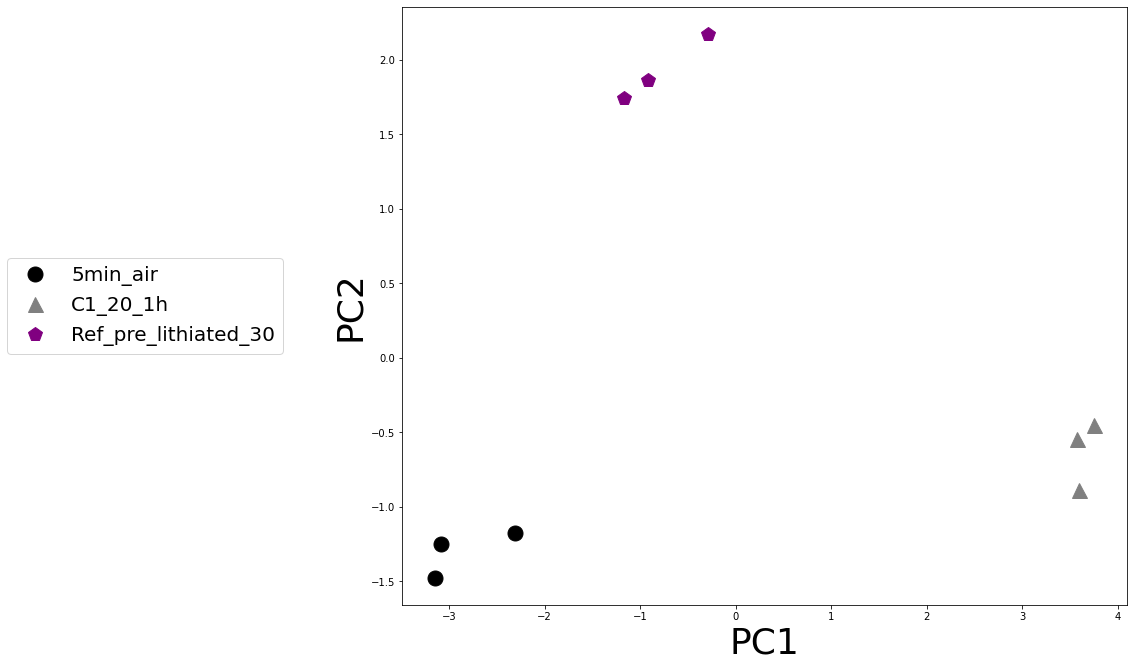

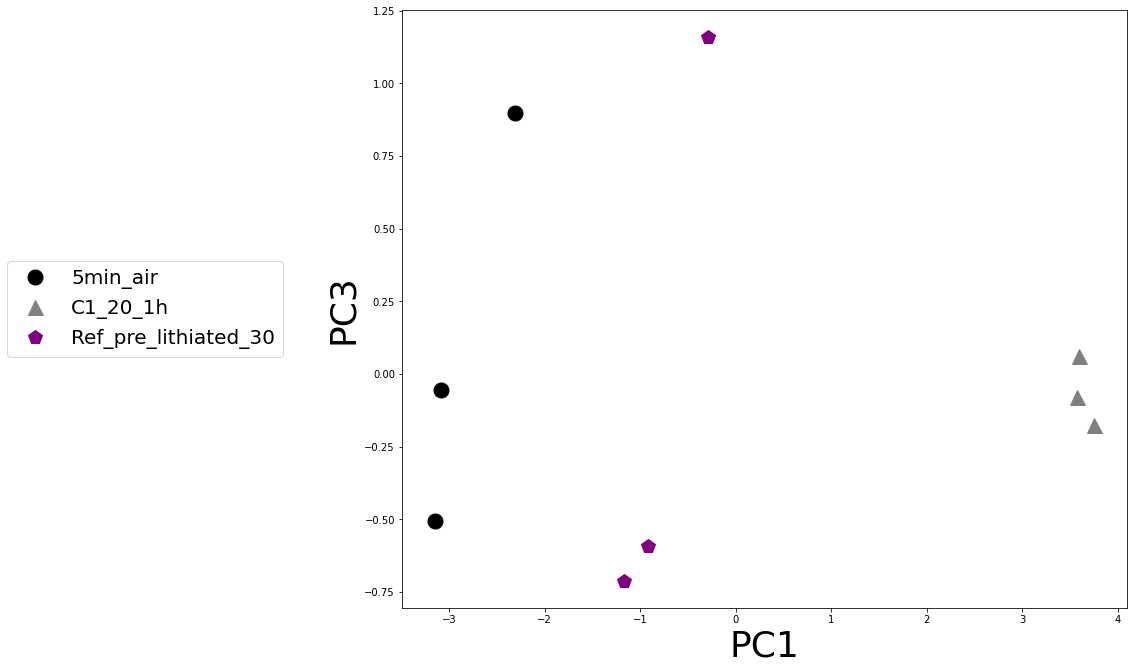

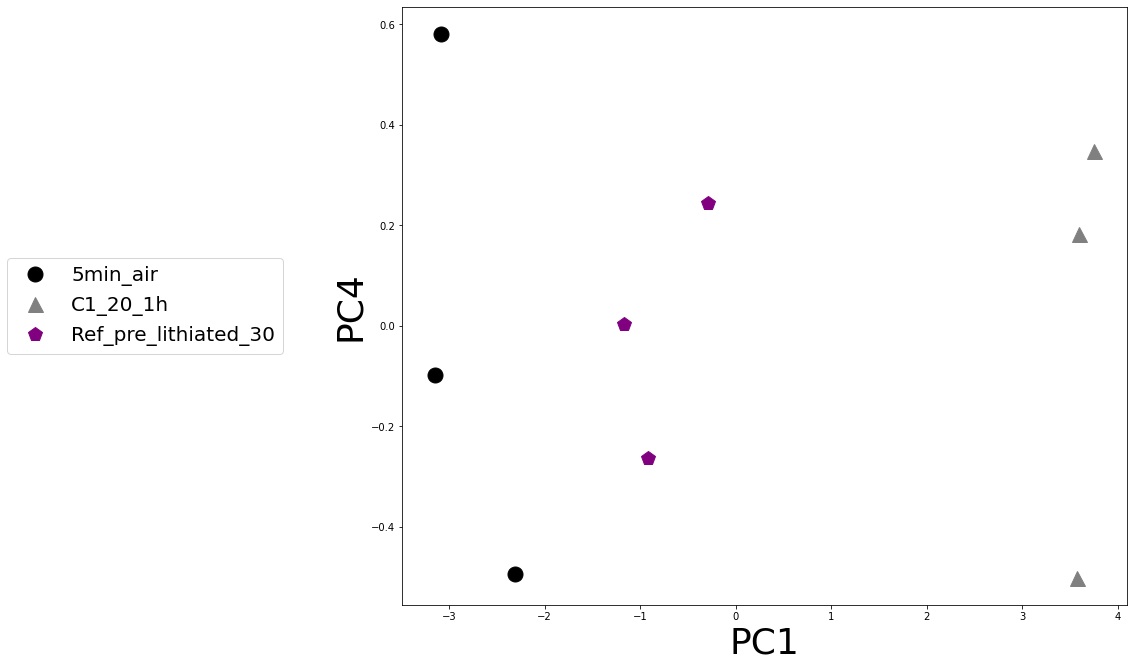

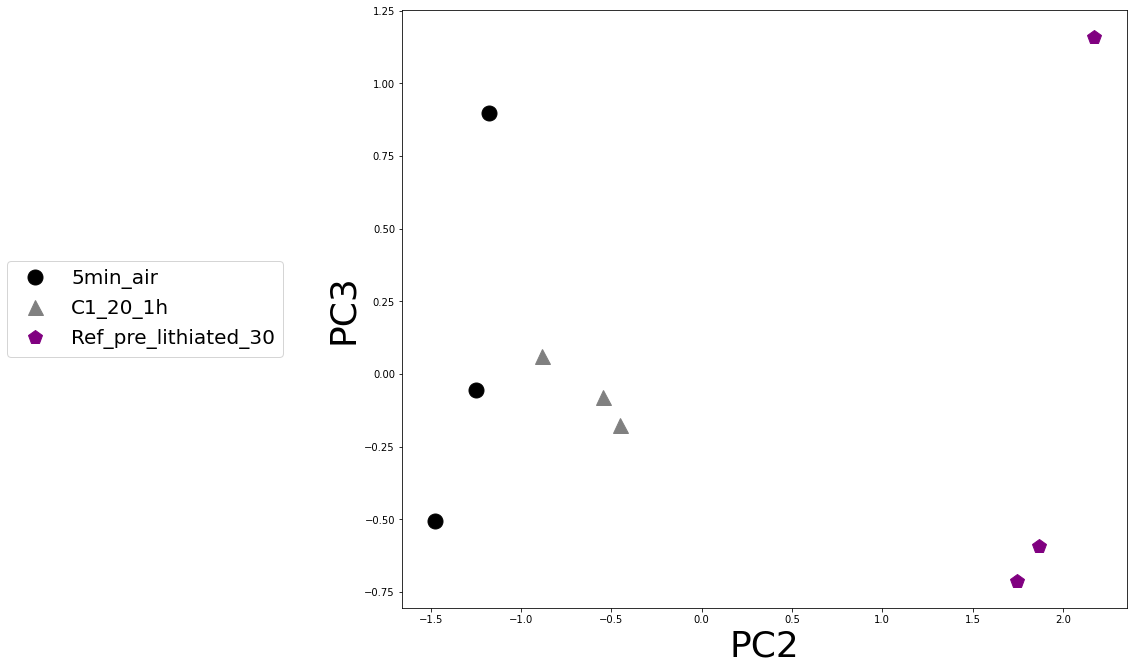

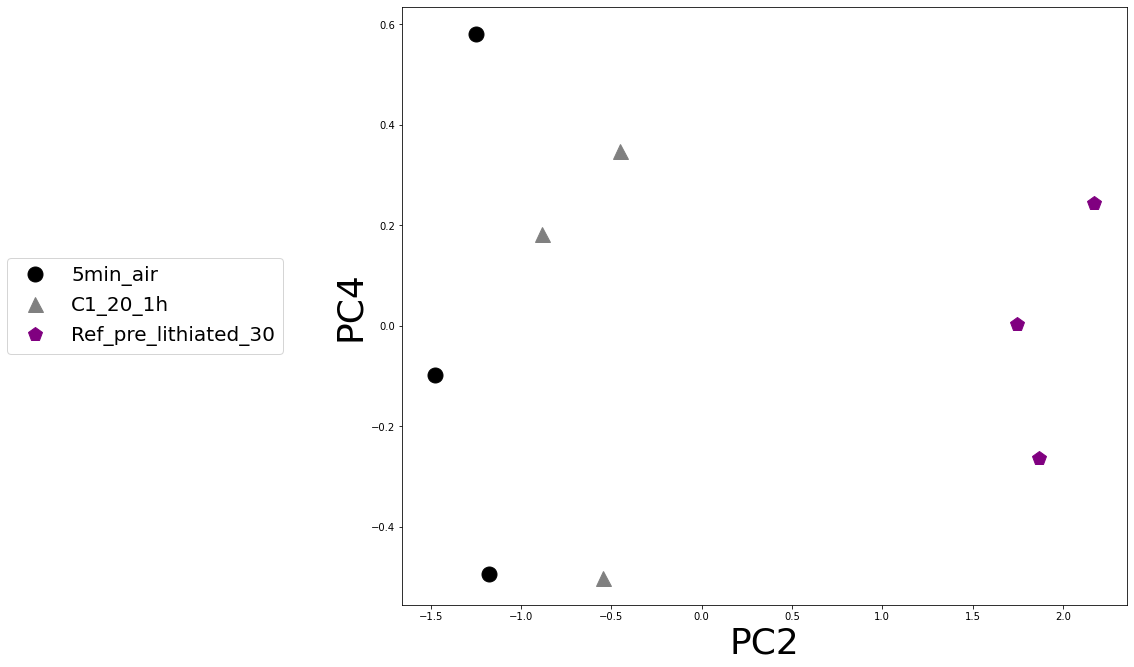

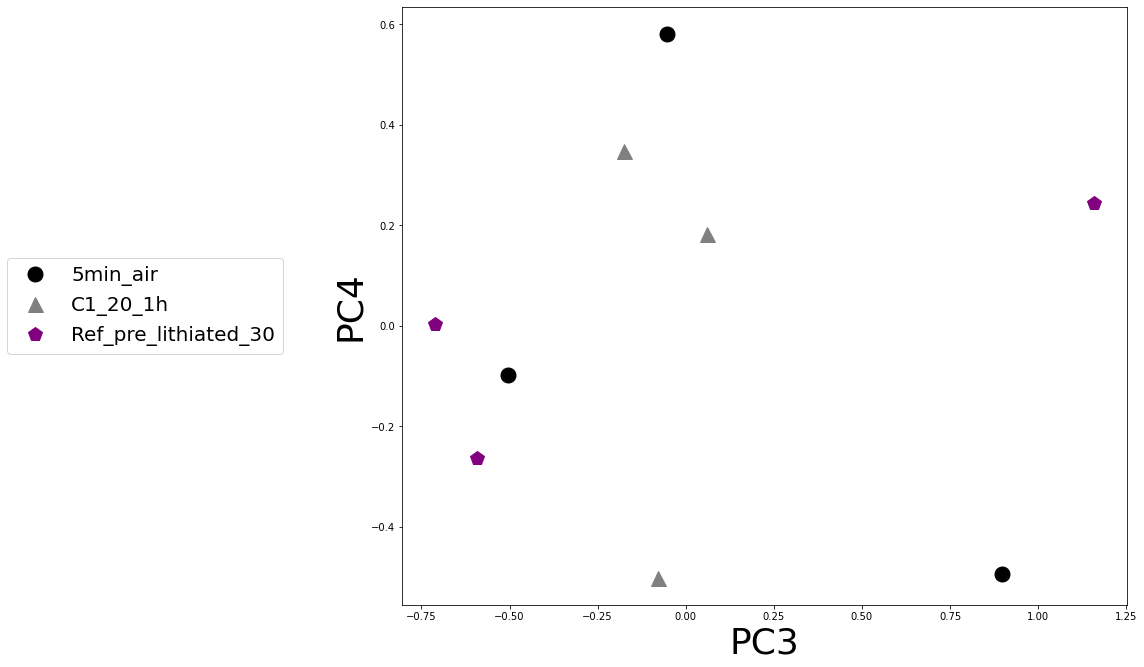

In [24]:
# Plotting data (divded by class) as a function of PC1/PC2 and PC3/PC4 
list_symbols = ["o", "^", "p", "*", "x", "d", "+", ">", "<", "1", "P", "s",
               "h", "X", "D", "$...$",'H',
               "o", "^", "p", "*", "x", "d", "+", ">", "<", "1", "P", "s",
               "h", "X", "D", "$...$",'H',
               "o", "^", "p", "*", "x", "d", "+", ">", "<", "1", "P", "s",
               "h", "X", "D", "$...$",'H']

list_color = ['black', "gray", 'purple', 'blue', 'cyan', 'green', 'olive', 'orange', 'red', 'pink',
             'black', "gray", 'purple', 'blue', 'cyan', 'green', 'olive', 'orange', 'red', 'pink',
             'black', "gray", 'purple', 'blue', 'cyan', 'green', 'olive', 'orange', 'red', 'pink',
             'black', "gray", 'purple', 'blue', 'cyan', 'green', 'olive', 'orange', 'red', 'pink']

# PC1 - PC2
fig, ax = plt.subplots(figsize=(13, 11))
count = 0
classes = []
for m in measurements_name:
    data_i = PCA_res_df[PCA_res_df["label"]==m]
    ax.plot(data_i["PC1"], data_i["PC2"], linewidth=0, markersize=15, color=list_color[count], marker=list_symbols[count], label=m)
    
    count+=1
ax.set_xlabel("PC1", fontsize=36) #fontweight="bold"
ax.set_ylabel("PC2", fontsize=36) #fontweight="bold"
legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

# Savefig
path_save = directory_res + "\\PCs1-2_score_plot.png"
plt.savefig(path_save, 
            dpi=300, 
            format='png', 
            bbox_extra_artists=(legend_outside,), 
            bbox_inches='tight')

# PC1 - PC3
fig, ax = plt.subplots(figsize=(13, 11))
count = 0
classes = []
for m in measurements_name:
    data_i = PCA_res_df[PCA_res_df["label"]==m]
    ax.plot(data_i["PC1"], data_i["PC3"], linewidth=0, markersize=15, color=list_color[count], marker=list_symbols[count], label=m)
    
    count+=1
ax.set_xlabel("PC1", fontsize=36) #fontweight="bold"
ax.set_ylabel("PC3", fontsize=36) #fontweight="bold"
legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

# Savefig
path_save = directory_res + "\\PCs1-3_score_plot.png"
plt.savefig(path_save, 
            dpi=300, 
            format='png', 
            bbox_extra_artists=(legend_outside,), 
            bbox_inches='tight')

# PC1 - PC4
fig, ax = plt.subplots(figsize=(13, 11))
count = 0
classes = []
for m in measurements_name:
    data_i = PCA_res_df[PCA_res_df["label"]==m]
    ax.plot(data_i["PC1"], data_i["PC4"], linewidth=0, markersize=15, color=list_color[count], marker=list_symbols[count], label=m)
    
    count+=1
ax.set_xlabel("PC1", fontsize=36) #fontweight="bold"
ax.set_ylabel("PC4", fontsize=36) #fontweight="bold"
legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

# Savefig
path_save = directory_res + "\\PCs1-4_score_plot.png"
plt.savefig(path_save, 
            dpi=300, 
            format='png', 
            bbox_extra_artists=(legend_outside,), 
            bbox_inches='tight')

# PC2 - PC3
fig, ax = plt.subplots(figsize=(13, 11))
count = 0
classes = []
for m in measurements_name:
    data_i = PCA_res_df[PCA_res_df["label"]==m]
    ax.plot(data_i["PC2"], data_i["PC3"], linewidth=0, markersize=15, color=list_color[count], marker=list_symbols[count], label=m)
    
    count+=1
ax.set_xlabel("PC2", fontsize=36) #fontweight="bold"
ax.set_ylabel("PC3", fontsize=36) #fontweight="bold"
legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

# Savefig
path_save = directory_res + "\\PCs2-3_score_plot.png"
plt.savefig(path_save, 
            dpi=300, 
            format='png', 
            bbox_extra_artists=(legend_outside,), 
            bbox_inches='tight')

# PC2 - PC4
fig, ax = plt.subplots(figsize=(13, 11))
count = 0
classes = []
for m in measurements_name:
    data_i = PCA_res_df[PCA_res_df["label"]==m]
    ax.plot(data_i["PC2"], data_i["PC4"], linewidth=0, markersize=15, color=list_color[count], marker=list_symbols[count], label=m)
    
    count+=1
ax.set_xlabel("PC2", fontsize=36) #fontweight="bold"
ax.set_ylabel("PC4", fontsize=36) #fontweight="bold"
legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

# Savefig
path_save = directory_res + "\\PCs2-4_score_plot.png"
plt.savefig(path_save, 
            dpi=300, 
            format='png', 
            bbox_extra_artists=(legend_outside,), 
            bbox_inches='tight')

# PC3 - PC4
fig, ax = plt.subplots(figsize=(13, 11))
count = 0
classes = []
for m in measurements_name:
    data_i = PCA_res_df[PCA_res_df["label"]==m]
    ax.plot(data_i["PC3"], data_i["PC4"], linewidth=0, markersize=15, color=list_color[count], marker=list_symbols[count], label=m)
    
    count+=1
ax.set_xlabel("PC3", fontsize=36) #fontweight="bold"
ax.set_ylabel("PC4", fontsize=36) #fontweight="bold"
legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

# Savefig
path_save = directory_res + "\\PCs3-4_score_plot.png"
plt.savefig(path_save, 
            dpi=300, 
            format='png', 
            bbox_extra_artists=(legend_outside,), 
            bbox_inches='tight')

In [ ]:
"""
# Plotting data (divded by class) as a function of PC1/PC2 and PC3/PC4 
list_symbols = ["o", "^", "p", "*", "x", "d", "+", "|", "_", "<", ">", "1", "P", "s"]

# Pc1 - PC2
fig, ax = plt.subplots(figsize=(13, 11))
count = 0
classes = []
for m in measurements_name:
    data_i = PCA_res_df[PCA_res_df["label"]==m]
    ax.plot(data_i["PC1"], data_i["PC2"], linewidth=0, markersize=15, color="gray", marker=list_symbols[count], label=m)
    
    data_ip = data_i.drop(labels="label", axis=1)
    predictions_i = gmm_model.predict(data_ip)
    count_point = 0
    for point in predictions_i:
        x = data_i["PC1"].tolist()[count_point]
        y = data_i["PC2"].tolist()[count_point]
        c = (point+1) / (max(predictions)+1)
        if point not in classes:
            name_label = "Class " + str(point+1)
            classes.append(point)
        ax.plot(x, y, linewidth=0, markersize=16, color=plt.cm.Paired(c), marker=list_symbols[count])
        count_point+=1
    count+=1

ax2 = ax.twinx()
custom_lines, ax2.legend = legend_lines(components)
# ax2.legend(custom_lines, ['Class1', 'Class2'], loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=24)
#ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))


ax.set_xlabel("PC1", fontsize=36) #fontweight="bold"
ax.set_ylabel("PC2", fontsize=36) #fontweight="bold"

# Legend 

legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))
legend_outside2 = ax2.legend

# Savefig
path_save = directory_res + "\\PCs1-2.png"
plt.savefig(path_save, 
            dpi=300, 
            format='png', 
            bbox_extra_artists=(legend_outside,), 
            bbox_inches='tight')

# PC1 - PC3
if len(exp_var_pca) > 2:
    fig, ax = plt.subplots(figsize=(13, 11))
    count = 0
    classes = []
    for m in measurements_name:
        data_i = PCA_res_df[PCA_res_df["label"]==m]
        ax.plot(data_i["PC1"], data_i["PC3"], linewidth=0, markersize=15, color="gray", marker=list_symbols[count], label=m)

        data_ip = data_i.drop(labels="label", axis=1)
        predictions_i = gmm_model.predict(data_ip)
        count_point = 0
        for point in predictions_i:
            x = data_i["PC1"].tolist()[count_point]
            y = data_i["PC3"].tolist()[count_point]
            c = (point+1) / (max(predictions)+1)
            if point not in classes:
                name_label = "Class " + str(point+1)
                classes.append(point)
            ax.plot(x, y, linewidth=0, markersize=16, color=plt.cm.Paired(c), marker=list_symbols[count])
            count_point+=1
        count+=1

    ax2 = ax.twinx()
    custom_lines, ax2.legend = legend_lines(components)

    ax.set_xlabel("PC1", fontsize=36) #fontweight="bold"
    ax.set_ylabel("PC3", fontsize=36) #fontweight="bold"

    # Legend 

    legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

    # Savefig
    path_save = directory_res + "\\PCs1-3.png"
    plt.savefig(path_save, 
                dpi=300, 
                format='png', 
                bbox_extra_artists=(legend_outside,), 
                bbox_inches='tight')

# PC1 - PC4
if len(exp_var_pca) > 3:
    fig, ax = plt.subplots(figsize=(13, 11))
    count = 0
    classes = []
    for m in measurements_name:
        data_i = PCA_res_df[PCA_res_df["label"]==m]
        ax.plot(data_i["PC1"], data_i["PC4"], linewidth=0, markersize=15, color="gray", marker=list_symbols[count], label=m)

        data_ip = data_i.drop(labels="label", axis=1)
        predictions_i = gmm_model.predict(data_ip)
        count_point = 0
        for point in predictions_i:
            x = data_i["PC1"].tolist()[count_point]
            y = data_i["PC4"].tolist()[count_point]
            c = (point+1) / (max(predictions)+1)
            if point not in classes:
                name_label = "Class " + str(point+1)
                classes.append(point)
            ax.plot(x, y, linewidth=0, markersize=16, color=plt.cm.Paired(c), marker=list_symbols[count])
            count_point+=1
        count+=1

    ax2 = ax.twinx()
    custom_lines, ax2.legend = legend_lines(components)

    ax.set_xlabel("PC1", fontsize=36) #fontweight="bold"
    ax.set_ylabel("PC4", fontsize=36) #fontweight="bold"

    # Legend 

    legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

    # Savefig
    path_save = directory_res + "\\PCs1-4.png"
    plt.savefig(path_save, 
                dpi=300, 
                format='png', 
                bbox_extra_artists=(legend_outside,), 
                bbox_inches='tight')

# PC2 - PC3
if len(exp_var_pca) > 2:
    fig, ax = plt.subplots(figsize=(13, 11))
    count = 0
    classes = []
    for m in measurements_name:
        data_i = PCA_res_df[PCA_res_df["label"]==m]
        ax.plot(data_i["PC2"], data_i["PC3"], linewidth=0, markersize=15, color="gray", marker=list_symbols[count], label=m)

        data_ip = data_i.drop(labels="label", axis=1)
        predictions_i = gmm_model.predict(data_ip)
        count_point = 0
        for point in predictions_i:
            x = data_i["PC2"].tolist()[count_point]
            y = data_i["PC3"].tolist()[count_point]
            c = (point+1) / (max(predictions)+1)
            if point not in classes:
                name_label = "Class " + str(point+1)
                classes.append(point)
            ax.plot(x, y, linewidth=0, markersize=16, color=plt.cm.Paired(c), marker=list_symbols[count])
            count_point+=1
        count+=1

    ax2 = ax.twinx()
    custom_lines, ax2.legend = legend_lines(components)

    ax.set_xlabel("PC2", fontsize=36) #fontweight="bold"
    ax.set_ylabel("PC3", fontsize=36) #fontweight="bold"

    # Legend 

    legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

    # Savefig
    path_save = directory_res + "\\PCs2-3.png"
    plt.savefig(path_save, 
                dpi=300, 
                format='png', 
                bbox_extra_artists=(legend_outside,), 
                bbox_inches='tight')

# PC2 - PC4
if len(exp_var_pca) > 3:
    fig, ax = plt.subplots(figsize=(13, 11))
    count = 0
    classes = []
    for m in measurements_name:
        data_i = PCA_res_df[PCA_res_df["label"]==m]
        ax.plot(data_i["PC2"], data_i["PC4"], linewidth=0, markersize=15, color="gray", marker=list_symbols[count], label=m)

        data_ip = data_i.drop(labels="label", axis=1)
        predictions_i = gmm_model.predict(data_ip)
        count_point = 0
        for point in predictions_i:
            x = data_i["PC2"].tolist()[count_point]
            y = data_i["PC4"].tolist()[count_point]
            c = (point+1) / (max(predictions)+1)
            if point not in classes:
                name_label = "Class " + str(point+1)
                classes.append(point)
            ax.plot(x, y, linewidth=0, markersize=16, color=plt.cm.Paired(c), marker=list_symbols[count])
            count_point+=1
        count+=1

    ax2 = ax.twinx()
    custom_lines, ax2.legend = legend_lines(components)

    ax.set_xlabel("PC2", fontsize=36) #fontweight="bold"
    ax.set_ylabel("PC4", fontsize=36) #fontweight="bold"

    # Legend 

    legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

    # Savefig
    path_save = directory_res + "\\PCs2-4.png"
    plt.savefig(path_save, 
                dpi=300, 
                format='png', 
                bbox_extra_artists=(legend_outside,), 
                bbox_inches='tight')

# PC3 - PC4
if len(exp_var_pca) > 3:
    fig, ax = plt.subplots(figsize=(13, 11))
    count = 0
    classes = []
    for m in measurements_name:
        data_i = PCA_res_df[PCA_res_df["label"]==m]
        ax.plot(data_i["PC3"], data_i["PC4"], linewidth=0, markersize=15, color="gray", marker=list_symbols[count], label=m)

        data_ip = data_i.drop(labels="label", axis=1)
        predictions_i = gmm_model.predict(data_ip)
        count_point = 0
        for point in predictions_i:
            x = data_i["PC3"].tolist()[count_point]
            y = data_i["PC4"].tolist()[count_point]
            c = (point+1) / (max(predictions)+1)
            if point not in classes:
                name_label = "Class " + str(point+1)
                classes.append(point)
            ax.plot(x, y, linewidth=0, markersize=16, color=plt.cm.Paired(c), marker=list_symbols[count])
            count_point+=1
        count+=1

    ax2 = ax.twinx()
    custom_lines, ax2.legend = legend_lines(components)

    ax.set_xlabel("PC3", fontsize=36) #fontweight="bold"
    ax.set_ylabel("PC4", fontsize=36) #fontweight="bold"

    # Legend 

    legend_outside = ax.legend(fontsize=20, loc='center right',bbox_to_anchor=(-0.15, 0.5))

    # Savefig
    path_save = directory_res + "\\PCs3-4.png"
    plt.savefig(path_save, 
                dpi=300, 
                format='png', 
                bbox_extra_artists=(legend_outside,), 
                bbox_inches='tight')
"""